https://www.tensorflow.org/tutorials/eager/automatic_differentiation

In [1]:
%matplotlib inline

In [2]:
from cbrain.imports import *

In [3]:
tf.enable_eager_execution()

## Load model

In [3]:
model = tf.keras.models.load_model('/home/s/S.Rasp/repositories/CBRAIN-CAM/saved_models/000_example/model.h5')

ValueError: optimizer must be an instance of tf.train.Optimizer, not a <class 'tensorflow.python.keras.optimizers.Adam'>

In [7]:
from cbrain.models import fc_model
from cbrain.data_generator import DataGenerator
from cbrain.utils import *

### Load data generator

In [5]:
DATADIR = '/local/S.Rasp/preprocessed_data/'

In [6]:
inputs = ['QBP', 'TBP', 'VBP', 'PS', 'SOLIN', 'SHFLX', 'LHFLX']
outputs = ['PHQ', 'TPHYSTND', 'FSNT', 'FSNS', 'FLNT', 'FLNS', 'PRECT']

In [8]:
scale_dict = load_pickle('/home/s/S.Rasp/repositories/CBRAIN-CAM/nn_config/scale_dicts/002_pnas_scaling.pkl')

In [12]:
gen.data_ds.close()

In [13]:
gen = DataGenerator(
    DATADIR + '001_train.nc', inputs, outputs, DATADIR + '001_norm.nc', input_transform=('mean', 'std_by_var'), 
    output_transform=scale_dict, shuffle=False, xarray=True
)

In [14]:
x, y = gen[0]

In [27]:
x = np.array(x); y=np.array(y)

### Create new model

In [15]:
model = fc_model(gen.n_inputs, gen.n_outputs, [256,256,256,256,256,256,256], 'LeakyReLU')

In [16]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 94)                0         
_________________________________________________________________
dense (Dense)                (None, 256)               24320     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 256)               0         
__________

In [17]:
model.load_weights('/home/s/S.Rasp/repositories/CBRAIN-CAM/saved_models/001_8col_pnas/weights.h5')

In [23]:
preds = model(x[None,:]).numpy()

In [28]:
preds.shape

(1, 1024, 65)

In [29]:
y.shape

(1024, 65)

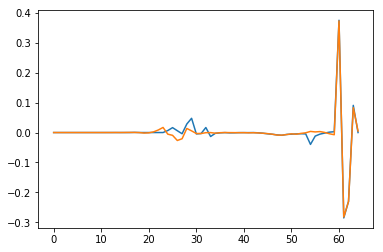

In [31]:
plt.plot(y[0])
plt.plot(preds[0, 0])

## Understand the gradient tape

In [22]:
model.layers

In [23]:
inp = model.layers[0]

In [24]:
inp.input

<DeferredTensor 'input_1' shape=(?, 94) dtype=float32>

In [37]:
model.input

<DeferredTensor 'input_1' shape=(?, 94) dtype=float32>

In [42]:
model.layers[1](x)

<tf.Tensor: id=462, shape=(1024, 128), dtype=float32, numpy=
array([[ 0.09379593, -0.04978857, -0.05938463, ...,  0.11074889,
         0.19220191, -0.08466128],
       [ 0.09325124, -0.05257552, -0.06338614, ...,  0.11193622,
         0.19138831, -0.08697981],
       [ 0.09158648, -0.05689365, -0.06659956, ...,  0.11134364,
         0.1916934 , -0.09038725],
       ...,
       [ 0.03305253, -0.04993528, -0.03993084, ...,  0.04665099,
         0.13997474, -0.08778962],
       [ 0.03051906, -0.03831708, -0.03008894, ...,  0.05329847,
         0.13294238, -0.0800683 ],
       [ 0.02697335, -0.03262495, -0.00803304, ...,  0.05267374,
         0.12903965, -0.08155697]], dtype=float32)>

In [ ]:
tf.Variable()

In [45]:
x_tf = tf.convert_to_tensor(x[0][None, :])

In [46]:
x_tf.shape

TensorShape([Dimension(1), Dimension(94)])

In [52]:
with tf.GradientTape() as tape:
    tape.watch(x_tf)
    preds = model(x_tf)
    out1 = preds[0, 0]
    

In [53]:
tape.gradient(out1, x_tf).numpy

<bound method _EagerTensorBase.numpy of <tf.Tensor: id=719, shape=(1, 94), dtype=float32, numpy=
array([[-0.07624864,  0.00357909,  0.01530752, -0.03146026,  0.00522509,
        -0.00319673, -0.00731618, -0.00717725, -0.00103196,  0.01712694,
        -0.02632021, -0.01716135,  0.00507083,  0.00122671,  0.00206406,
         0.00051986, -0.00690468,  0.02634127, -0.01640013,  0.01360981,
        -0.01938783,  0.04221768,  0.03856042,  0.00310179,  0.02677481,
         0.0285799 ,  0.00077943, -0.00621569, -0.06528486, -0.06595019,
         0.01187528, -0.04456734,  0.02437765, -0.01502825, -0.0080694 ,
        -0.00034837,  0.03027583, -0.01803453, -0.00773496,  0.05744822,
         0.01167385, -0.03673278, -0.01240732, -0.01614456, -0.00491234,
         0.01424513, -0.01737286,  0.00200419, -0.02133173, -0.01210732,
        -0.02443455, -0.01633992, -0.0209528 , -0.02892042, -0.0052209 ,
         0.07778975,  0.03522721, -0.08162752, -0.00817209,  0.02538885,
         0.00814412, -0.031

In [32]:
def get_jacobian(sample_x):
    x_tf = tf.convert_to_tensor(sample_x)
    J = np.zeros((gen.n_outputs, gen.n_inputs))
    for i in range(gen.n_outputs):
        with tf.GradientTape() as tape:
            tape.watch(x_tf)
            preds = model(x_tf)
            out1 = preds[0, i]
        grads = tape.gradient(out1, x_tf).numpy()
        J[i, :] = grads
    return J

In [35]:
x = x.astype(np.float32)

In [36]:
J = get_jacobian(x[400][None, :])

In [120]:
J.max(), J.min()

(1.0531011819839478, -0.7370100021362305)

In [121]:
gen.norm_ds.var_names[gen.input_idxs]

<xarray.DataArray 'var_names' (var_names: 94)>
array(['TBP', 'TBP', 'TBP', 'TBP', 'TBP', 'TBP', 'TBP', 'TBP', 'TBP', 'TBP',
       'TBP', 'TBP', 'TBP', 'TBP', 'TBP', 'TBP', 'TBP', 'TBP', 'TBP', 'TBP',
       'TBP', 'TBP', 'TBP', 'TBP', 'TBP', 'TBP', 'TBP', 'TBP', 'TBP', 'TBP',
       'QBP', 'QBP', 'QBP', 'QBP', 'QBP', 'QBP', 'QBP', 'QBP', 'QBP', 'QBP',
       'QBP', 'QBP', 'QBP', 'QBP', 'QBP', 'QBP', 'QBP', 'QBP', 'QBP', 'QBP',
       'QBP', 'QBP', 'QBP', 'QBP', 'QBP', 'QBP', 'QBP', 'QBP', 'QBP', 'QBP',
       'VBP', 'VBP', 'VBP', 'VBP', 'VBP', 'VBP', 'VBP', 'VBP', 'VBP', 'VBP',
       'VBP', 'VBP', 'VBP', 'VBP', 'VBP', 'VBP', 'VBP', 'VBP', 'VBP', 'VBP',
       'VBP', 'VBP', 'VBP', 'VBP', 'VBP', 'VBP', 'VBP', 'VBP', 'VBP', 'VBP',
       'PS', 'SOLIN', 'SHFLX', 'LHFLX'], dtype=object)
Coordinates:
  * var_names  (var_names) object 'TBP' 'TBP' 'TBP' ... 'SOLIN' 'SHFLX' 'LHFLX'

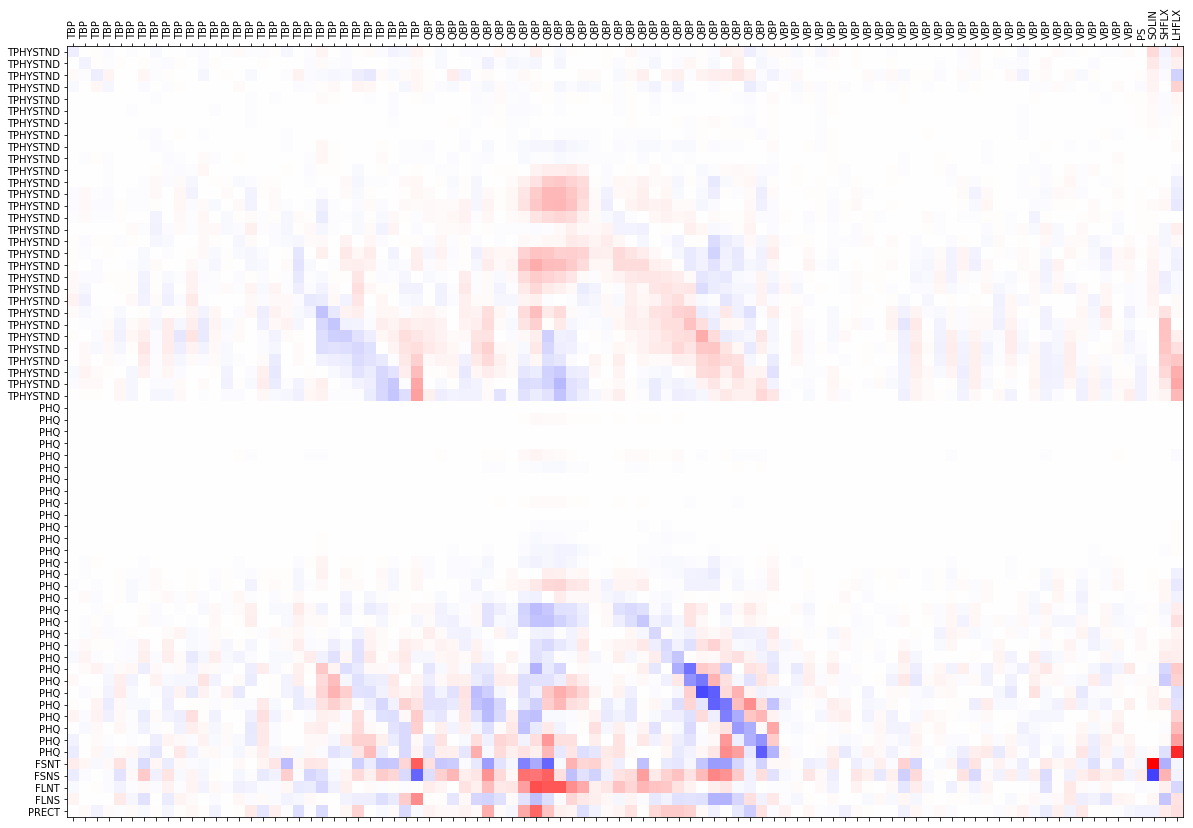

In [122]:
fig, ax = plt.subplots(figsize=(20,20))
ax.matshow(J, vmin=-1, vmax=1, cmap='bwr')
plt.xticks(range(gen.n_inputs), gen.norm_ds.var_names[gen.input_idxs].values, rotation=90);
plt.yticks(range(gen.n_outputs), gen.norm_ds.var_names[gen.output_idxs].values, rotation=0);

## Compute eigenvalues and vectors

In [123]:
from numpy import linalg as LA

In [124]:
w, v = LA.eig(J[:60, :60])

In [125]:
v.shape, w.shape

((60, 60), (60,))

<BarContainer object of 60 artists>

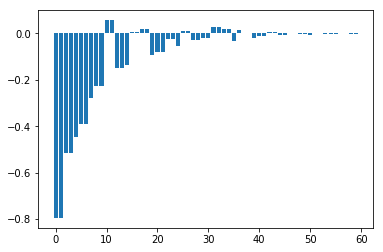

In [126]:
plt.bar(range(60), np.real(w))

In [127]:
np.argmax(np.real(w))

10

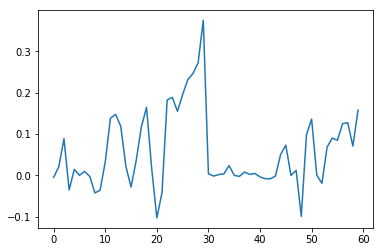

In [128]:
plt.plot(v[:, 11])

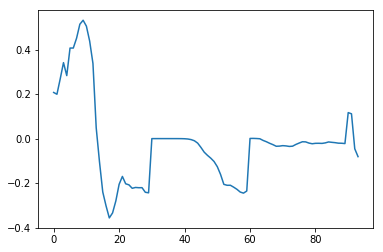

In [113]:
plt.plot(x[0])